# Grover Adaptive Search - GAS

Veamos como usar Grover para optimización. En particular:

- Formulaciones QUBO (Quadratic Unconstrained Binary Optimization): $\min_{x \in \{0, 1 \}^n} \{f(x)\}$ donde:

$$f(x) = \sum_{i, j} Q_{i, j} x_i x_j$$

- Formulaciones CPBO (Constrained Polynomial Binary Optimization): más general que QUBO, $f(x)$ puede ser un polinomio de cualquier orden. 


Vamos a centrarnos en el caso donde todos los coeficientes del polinomio son enteros. Para el caso de QUBO, implica que $Q_{i, j} \in \mathbb{Z}$.

## Uso del algoritmo de Grover

La idea es generar un operador de Grover que amplifique los elementos que cumplen $f(x) < y$ para cualquier $y \in \mathbb{Z}$. Esto nos permitirá iterativamente mejorar el valor del mínimo.

Vamos a agregar un registro auxiliar de $m$ qubits para guardar el valor de $\ket{f(x) - y}$. Necesitamos dos operaciones:

$$U_1 \ket{x_1 x_2 \dots x_n}\ket{0}^{\otimes m}\ket{z} = \ket{x_1 x_2 \dots x_n}\ket{f(x) - y}_m\ket{z}$$

$$U_2\ket{x_1 x_2 \dots x_n}\ket{f(x) - y}_m\ket{z} = \ket{x_1 x_2 \dots x_n}\ket{f(x) - y}_m\ket{z \oplus \left( f(x) - y < 0 \right)}$$

El oráculo $O$ que implementa:

$$O\ket{x_1 x_2 \dots x_n}\ket{z} = \ket{x_1 x_2 \dots x_n}\ket{z \oplus \left( f(x) - y < 0 \right)}$$

Se puede lograr haciendo $O = U_1^{\dagger} U_2 U_1$ y descartando los $m$ qubits auxiliares, que quedarán en $\ket{0}^{\otimes m}$ listos para una nueva aplicación del oráculo.



### Implementación de $U_1$:

Definimos el operador $U_G(\theta)$, que actúa en $m$ qubits como:

$$U_G(\theta)\ket{y}_m = e^{i y \theta} \ket{y}_m$$

Notemos que $U_G(\theta)U_G(\phi) = U_G(\theta + \phi)$, ya que:

$$U_G(\theta)U_G(\phi)\ket{y} = U_G(\theta)e^{iy\phi}\ket{y} = e^{iy\theta} e^{iy\phi}\ket{y} = e^{iy(\theta + \phi)}\ket{y}$$

Podemos implementar esta operación con una compuerta $R(2^{m - k }\theta)$ en el qubit $k$ para $k = 1, 2, \dots, m$, siendo:

$$R(\theta) = \begin{bmatrix}
    1 & 0 \\ 0 & e^{i\theta}
\end{bmatrix}$$

La compuerta $R(\theta)$ se puede agregar a un circuito `qc` con `qc.p(theta, qubit)`. Además, en `qiskit.circuit.library` tenemos disponible `CPhaseGate`, que implementa $R(\theta)$ controlada por un qubit, por lo que se puede implementar $R(\theta)$ controlada por cualquier cantidad de qubits sin problemas. Por tanto, también se puede implementar $U_G(\theta)$ controlada por cualquier cantidad de qubits sin problema. 

Lo último que debemos notar para evidenciar cómo implementar $U_1$ es que:

$$(\text{QFT})^{\dagger} U_G\left( \frac{2\pi}{2^{m}} k \right)H^{\otimes m}\ket{0}^{\otimes m} = \ket{k \hspace{2pt} (\text{mod } 2^{m})}_m$$

Por tanto, $U_1$ se puede aplicar de la siguiente forma:

- Comenzando en $\ket{x_1 x_2 \dots x_n}\ket{0}^{\otimes m}\ket{z}$, aplicar $H^{\otimes m}$ en el segundo registro.
- Para cada $Q_{i, j} \not= 0$, implementar la operación $U_G(2\pi / 2^{m} Q_{i, j})$ en el segundo registro, controlada por $\ket{x_i}$, $\ket{x_j}$. Si $i = j$, implementar $U_G(2\pi / 2^{m} Q_{i, j})$ controlada sólo por el qubit $\ket{x_i}$.
- Aplicar $U_G(2\pi / 2^{m} (-y))$ en el segundo registro.
- Aplicar una transformada inversa de Fourier en el segundo registro.

Luego de las operaciones obtendremos: 

$$\ket{x_1 x_2 \dots x_n}\ket{f(x) - y \hspace{2pt} (\text{mod } 2^{m})}_m\ket{z}$$

Esto nos indica que debemos elegir la cantidad de qubits $m$ de forma de poder representar los valores de $f(x)- y$ en complemento a 2.



### Implementación de $U_2$

Como $f(x)-y$ está en complemento a 2, el valor del primer qubit del registro auxiliar de $m$ qubits determina el signo de $f(x)-y$. Podemos implementar un CNOT con control en el primer qubit del registro auxiliar y target en $\ket{z}$.


## Grover Adaptive Search - Algoritmo completo: 

Ahora que podemos usar Grover para, dado un $y$, buscar una entrada con $f(x) < y$, el algoritmo de minimizacón queda como:

- Inicializar $i = 0$, $y_0 = 0$, y $x^{(0)} = (x_1^{(0)}, x_2^{(0)}, \dots, x_n^{(0)}) = (0, 0, \dots, 0)$.

- Aplicar el algoritmo de Grover para obtener un estado tal que $f(x) < y_i$. Repetir la cantidad necesaria de veces para asegurar una alta probabilidad de encontrar un $x$ válido, en caso de existir.

- Si se encuentra un $x$ tal que $f(x) < y_i$, actualizar: $y_{i+1} = f(x)$, $x^{(i+1)} = x$, $i \leftarrow i + 1$, y volver al paso anterior.  

- En caso contrario, retornar $x^{(i)}$ como el estado que minimiza la función objetivo.

In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.primitives import StatevectorSampler
from qiskit.circuit.library import ZGate, CPhaseGate
from qiskit.visualization import plot_histogram

import math

## Ejemplo - max-cut:

El problema de max-cut consiste en, dado un grafo $(V, E)$, encontrar dos conjuntos de vértices $V_1$ y $V_2$ tales que $V = V_1 \cup V_2$ que maximicen la cantidad de aristas entre $V_1$ y $V_2$. Se puede pensar como una coloración de los vértices del grafo en dos colores de forma de maximizar las aristas entre vértices de distinto color. 

Una formulación QUBO para el problema toma variables binarias $x_i$ para $i \in V$, de forma que si $x_i = 0$ entonces $i \in V_1$, mientras que si $x_i = 1$ entonces $i \in V_2$. Así, la cantidad de aristas $T$ entre nodos de $V_1$ y $V_2$ se calcula como:

$$T = \sum_{ij \in E} (x_i - x_j)^{2} = \sum_{i} d_i x_i - \sum_{ij \in E} 2x_ix_j$$

Donde $d_i$ es el grado del vértice $i$. Buscamos maximizar esta expresión. Como en una formulación QUBO se busca el mínimo, tomamos $f(x) = -T$. Así, buscamos minimizar:

$$f(x) =  -\sum_{i} d_i x_i + \sum_{ij \in E} 2x_ix_j$$

Por tanto:

$$Q_{i, j} = \begin{cases} -d_i & \text{si } i = j \\ 
                            2 & \text{si } ij \in E \\ 
                            0 & \text{en otro caso} 
                        \end{cases}$$


In [31]:
# Max-Cut problem on a 5-node graph with edges: (0,1), (0,2), (0,4), (1,2), (1,3), (1,4), (2,3), (3,4)
# Objective: partition nodes into two sets to maximize edges between sets
qubo = {
    # Linear terms (minus d_i - degree of each node)
    (0): -3,
    (1): -4,
    (2): -3,
    (3): -3,
    (4): -3,
    
    # Quadratic terms (edges between nodes)
    (0, 1): 2,
    (0, 2): 2,
    (1, 2): 2,
    (1, 3): 2,
    (1, 4): 2,
    (2, 3): 2,
    (3, 4): 2,
    (4, 0): 2,
}
variables = max([max(q) if isinstance(q, (list, tuple)) else q for q in qubo.keys()]) + 1 # Add one because we start counting from 0

# Get lower bound for min(Q) and upper bound for max(Q):
min_qubo = 0
max_qubo = 0
for key in qubo.keys():
    if qubo[key] < 0:
        min_qubo += qubo[key]

    else:
        max_qubo += qubo[key]

print(f" > Binary variables: {variables}")
print(f" > Range of possible values of Q(x): {(min_qubo, max_qubo)}")

# We want a value of m such that -2^{m-1} <= f(x) - y < 2^{m-1} for any value of x, y.
# Since it does not makes sense to set y > 0 not y < min_qubo:
# min(f(x) - y) >= 2*min_qubo
# max(f(x) - y) <= max_qubo
print(f" > Range needed to cover in second register with 2-complement: {(2*min_qubo, max_qubo)}")
m = math.ceil(math.log2(max(abs(2*min_qubo), max_qubo))) + 1
print(f" > Qubits used in second register to cover that range: {m}")

 > Binary variables: 5
 > Range of possible values of Q(x): (-16, 16)
 > Range needed to cover in second register with 2-complement: (-32, 16)
 > Qubits used in second register to cover that range: 6


In [26]:
# Solve the QUBO problem by searchin thorug all possible combination of variables
def evaluate_QUBO(sol):
    evaluation = 0

    for key in qubo.keys():
        if isinstance(key, (list, tuple)):
            evaluation += sol[key[0]]*sol[key[1]]*qubo[key]

        else:
            evaluation += sol[key]*qubo[key]

    return evaluation

min_sol = 0
best_sol = [0 for _ in range(variables)]
for i in range(2**variables):
    bin_string = bin(i)[2::]
    bin_string = '0'*(variables - len(bin_string)) + bin_string
    
    sol = [int(b) for b in bin_string]

    check_sol = evaluate_QUBO(sol)
    if check_sol < min_sol:
        min_sol = check_sol
        best_sol = sol

print(f" > Best solution: {best_sol}")
print(f" > Minimum value of f(x): {min_sol}")

 > Best solution: [0, 0, 1, 0, 1]
 > Minimum value of f(x): -6


In [5]:
def qft(qc, qr, qubits_list = None, swaps = False):
    '''
    Append the QFT operator to a quantum circuit qc.

    Args:
        - qc (QuantumCircuit): Qiskit Quantum Circuit
        - qr (QuantumRegister): Qiskit Quantum Register in which to apply the QFT
        - qubits_list (int[]): List indicating the order of the qubits. If None, we select the natural order (from zero to the number of qubits in qr)
        - swaps (bool): If True, perform swap operations before the QFT

    Returns:
        - None
    '''

    if (qubits_list == None):
        qubits_list = [i for i in range(len(qr))]

    n = len(qubits_list)
    for i in range(n):

        qc.h(qr[qubits_list[i]])

        for j in range(i + 1, n):
            phase = 2 * math.pi / (2**(2 + j - (i + 1)))
            qc.cp(phase, qr[qubits_list[j]], qr[qubits_list[i]])

    
    if swaps:
        for i in range(int(n/2)):
            qc.swap(qr[qubits_list[i]], qr[qubits_list[(n-1)-i]])

    return


def iqft(qc, qr, qubits_list = None, swaps = False):
    '''
    Append the Inverse QFT (IQFT) operator to a quantum circuit qc.

    Args:
        - qc (QuantumCircuit): Qiskit Quantum Circuit
        - qr (QuantumRegister): Qiskit Quantum Register in which to apply the IQFT
        - qubits_list (int[]): List indicating the order of the qubits. If None, we select the natural order (from zero to the number of qubits in qr)
        - swaps (bool): If True, perform swap operations before the IQFT

    Returns:
        - None
    '''

    if (qubits_list == None):
        qubits_list = [i for i in range(len(qr))]

    n = len(qubits_list)


    if swaps:
        for i in range(int(n/2)):
            qc.swap(qr[qubits_list[i]], qr[qubits_list[(n-1)-i]])


    for i in range(n):

        k = (n - 1) - i
        for j in range(k + 1, n):
            phase = - 2 * math.pi / (2**(2 + j - (k + 1)))
            qc.cp(phase, qr[qubits_list[j]], qr[qubits_list[k]])

        qc.h(qr[qubits_list[k]])

    
    return

def U_G(qc, qr, theta, qubit_list = None):
    '''
    Append the Gate U_G(theta) to a quantum circuit qc

    Args:
        - qc (QuantumCircuit): Qiskit Quantum Circuit
        - qr (QuantumRegister): Qiskit Quantum Register in which to apply the IQFT
        - theta (float): Parameter of the gate U_G
        - qubits_list (int[]): List indicating the order of the qubits. If None, we select the natural order (from zero to the number of qubits in qr)

    Returns:
        - None
    '''

    if (qubit_list == None):
        qubit_list = [i for i in range(len(qr))]

    m = len(qubit_list)

    for i, q in enumerate(qubit_list):
        qc.p(2**(m - i - 1)*theta, qr[q])

    return


def controlled_U_G(qc, qr, theta, control, qubit_list = None):
    '''
    Append the Gate controlled-U_G(theta) to a quantum circuit qc, controlled by qubit control

    Args:
        - qc (QuantumCircuit): Qiskit Quantum Circuit
        - qr (QuantumRegister): Qiskit Quantum Register in which to apply the IQFT
        - theta (float): Parameter of the gate U_G
        - control (int or QuantumRegister[i]): Control qubit
        - qubits_list (int[]): List indicating the order of the qubits. If None, we select the natural order (from zero to the number of qubits in qr)
        
    Returns:
        - None
    '''

    if (qubit_list == None):
        qubit_list = [i for i in range(len(qr))]

    m = len(qubit_list)

    for i, q in enumerate(qubit_list):
        qc.cp(2**(m - i - 1)*theta, qr[q], control)

    return


def double_controlled_U_G(qc, qr, theta, controls, qubit_list = None):
    '''
    Append the Gate controlled^2-U_G(theta) to a quantum circuit qc, controlled by qubits in controls

    Args:
        - qc (QuantumCircuit): Qiskit Quantum Circuit
        - qr (QuantumRegister): Qiskit Quantum Register in which to apply the IQFT
        - theta (float): Parameter of the gate U_G
        - controls (int[] or QuantumRegister[i][]): Control qubits
        - qubits_list (int[]): List indicating the order of the qubits. If None, we select the natural order (from zero to the number of qubits in qr)
        
    Returns:
        - None
    '''
    if (qubit_list == None):
        qubit_list = [i for i in range(len(qr))]

    m = len(qubit_list)

    for i, q in enumerate(qubit_list):

        CCP = CPhaseGate(2**(m - i - 1)*theta).control(1)

        qc.append(CCP, [controls[0], controls[1], qr[q]])

    return

### Test de la compuerta $U_G$ multicontrolada

Vamos a testear el comportamiento de la compuerta $U_G$ multicontrolada, en particular de la función `double_controlled_U_G()`. Para esto, verificaremos la propiedad:  

$$(\text{QFT})^{\dagger} U_G\left( \frac{2\pi}{2^{m}} k \right)H^{\otimes m}\ket{0}^{\otimes m} = \ket{k \hspace{2pt} (\text{mod } 2^{m})}_m$$

Los dos qubits de control comienzan en el estado $\ket{1}$, por lo que se debería medir $k$ en complemento a 2 en los qubits donde se aplica $U_G$.  

Si modificamos el código para que los qubits de control estén en un estado de la base computacional distinto de $\ket{11}$, entonces deberíamos obtener 0.

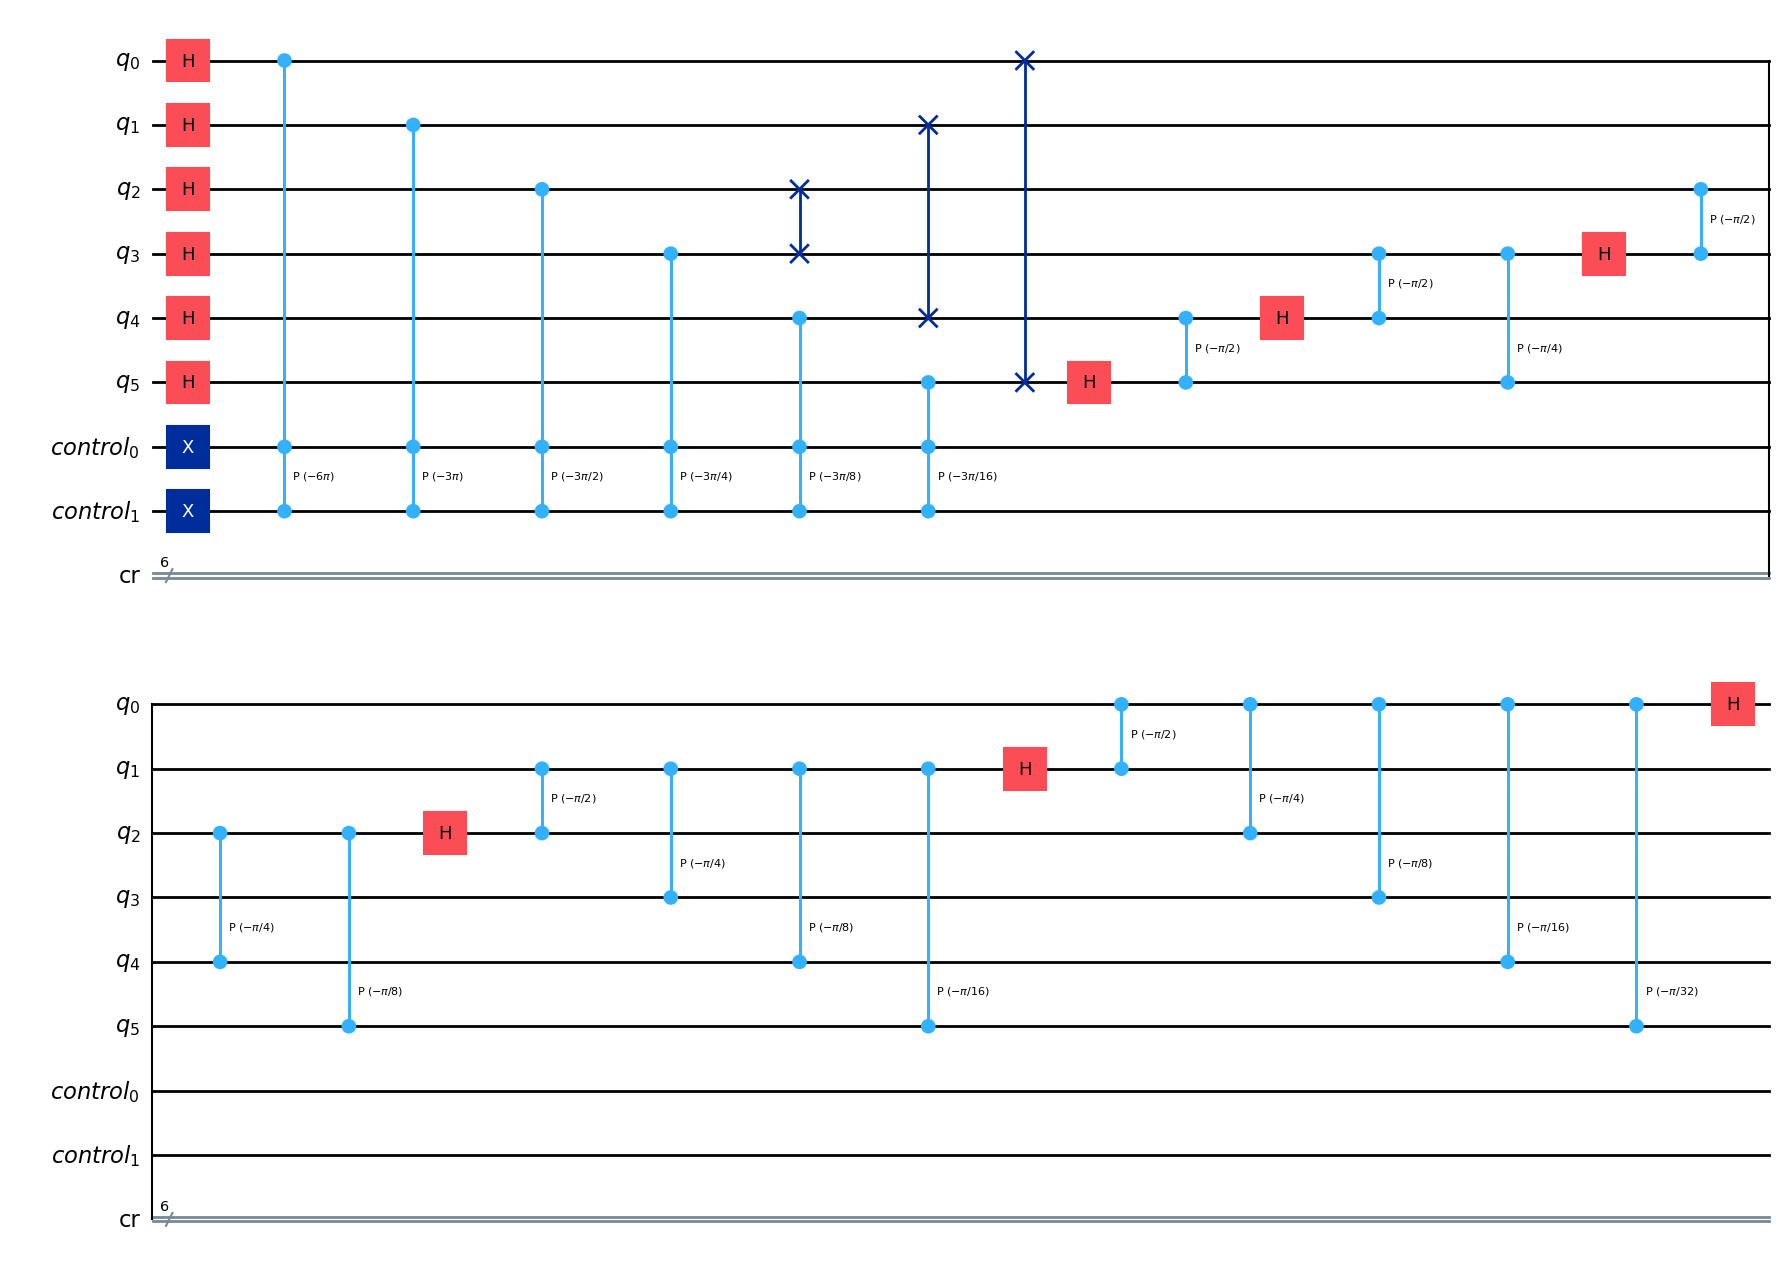

In [6]:
# Test double_controlled_U_G gate. 
# Testing that (IQFT)*C^2(U_G)*H|0> = |k (mod 2^m)>
# The result of the circuit should be |3 mod 2^m>
qubit_count = m
qr = QuantumRegister(qubit_count, 'q')
cr = ClassicalRegister(qubit_count, 'cr')
control = QuantumRegister(2, 'control')
qc = QuantumCircuit(qr, control, cr)

qc.x(control)

qc.h(qr)

k = -6
double_controlled_U_G(qc, qr, 2*math.pi/(2**m) * (k), control)
iqft(qc, qr, swaps=True)


qc.draw("mpl")

In [7]:
qc.measure(qr, cr)

# Instanciar Statevector
sampler = StatevectorSampler()
shots = 100000
 

job = sampler.run([qc], shots=shots)
 
# Extract the result for the 0th pub (this example only has one pub).
result = job.result()[0]
counts = result.data.cr.get_counts()



print(f"Test of double controlled U_G with k = {k}: {counts}")
k_binary = next(iter(counts))[::-1]
print(f"Output with order reversed: {k_binary}")
print(f"Output to integer with 2-complement: {sum([int(b)*2**i for i, b in enumerate(k_binary[::-1])]) - 2**qubit_count * int(k_binary[0] == '1')}")

Test of double controlled U_G with k = -6: {'010111': 100000}
Output with order reversed: 111010
Output to integer with 2-complement: -6


In [8]:
def oracle1(qc, qr, y = 0, qubits_list = None):
    '''
    Append the Grover oracle for GAS to a quantum circuit qc.
    This oracle uses phase-kickback

    Args:
        - qc (QuantumCircuit): Qiskit Quantum Circuit
        - qr (QuantumRegister): Qiskit Quantum Register in which to apply the oracle
        - qubits_list (int[]): list that indicates the order of the qubits. If None we select the natural order (From zero to the amount of qubits in qr)

    Returns:
        - None
    '''

    if (qubits_list == None):
        qubits_list = [i for i in range(len(qr))]

    n = len(qubits_list)

    principal_qubits = qubits_list[0:variables]
    ancillas = qubits_list[variables:variables+m]
    pkb_qubit = qubits_list[n-1]

    qc.h(ancillas)
    for key in qubo.keys():
        value = qubo[key]
        if isinstance(key, (list, tuple)):
            double_controlled_U_G(qc, ancillas,  2*math.pi/(2**m) * value, [principal_qubits[key[0]], principal_qubits[key[1]]])
            

        else:
            controlled_U_G(qc, ancillas,  2*math.pi/(2**m) * value, principal_qubits[key])

    
    U_G(qc, ancillas, - 2*math.pi/(2**m) * y)

    iqft(qc, ancillas, swaps = True)

    # The first ancilla indicates a negative value:

    qc.cx(ancillas[0], pkb_qubit)

    qft(qc, ancillas, swaps = True)

    U_G(qc, ancillas, + 2*math.pi/(2**m) * y)

    for key in qubo.keys():
        value = qubo[key]
        if isinstance(key, (list, tuple)):
            double_controlled_U_G(qc, ancillas,  - 2*math.pi/(2**m) * value, [principal_qubits[key[0]], principal_qubits[key[1]]])
            

        else:
            controlled_U_G(qc, ancillas, - 2*math.pi/(2**m) * value, principal_qubits[key])

    qc.h(ancillas)


    return



def grover(qc, qr, oracle_f, y = 0, ancilla = None, iterations = None, qubits_list = None):
    '''
    Append the Grover algorithm circuit to a quantum circuit qc. Assuming that all qubits start at |0>

    Args:        
        - qc (QuantumCircuit): Qiskit Quantum Circuit
        - qr (QuantumRegister): Qiskit Quantum Register in which to apply the Grover operator
        - oracle_f: Function that appends the oracle to the circuit. Receives a QuantumCircuit, a QuantumRegister, and a qubits_list
        - ancilla (QuantumRegister): Quantum Register for the ancilla qubits. Might be more than just one qubit if the oracle needs extra auxiliary qubits
        - iterations (int): Number of iterations to apply. If None, apply one iteration
        - qubits_list (int[]): list indicating the order of the qubits. If None, the natural order is used (from zero to the number of qubits in qr)

    Returns: 
        - None
    '''


    if not iterations:
        iterations = 1

    if (qubits_list == None):
        qubits_list = [i for i in range(len(qr))]

    n = len(qubits_list)

    # Estado inicial de la ancilla
    if ancilla:
        qc.x(ancilla[-1])
        qc.h(ancilla[-1])

    # Estado inicial del registro principal
    qc.h(qubits_list)
    
    for _ in range(iterations):
        qc.barrier()
        # Agregar oraculo O_f con ancilla
        if ancilla:

            oracle_f(qc, qubits_list + [anc for anc in ancilla], y = y)
        else:
            oracle_f(qc, qubits_list)
        qc.barrier()

        # Agregar operador de difusión:
        qc.h(qubits_list)
        qc.x(qubits_list)
        qc.append(ZGate().control(n - 1), qubits_list)
        qc.x(qubits_list)
        qc.h(qubits_list)

### Test del oráculo

Vamos a testear el oráculo para un estado aleatorio de la base computacional.  

Si $f(\text{test\_state}) < y$, entonces el último qubit (el qubit de la izquierda al medir) debe estar en 1. En otro caso, el qubit se debería medir en 0.


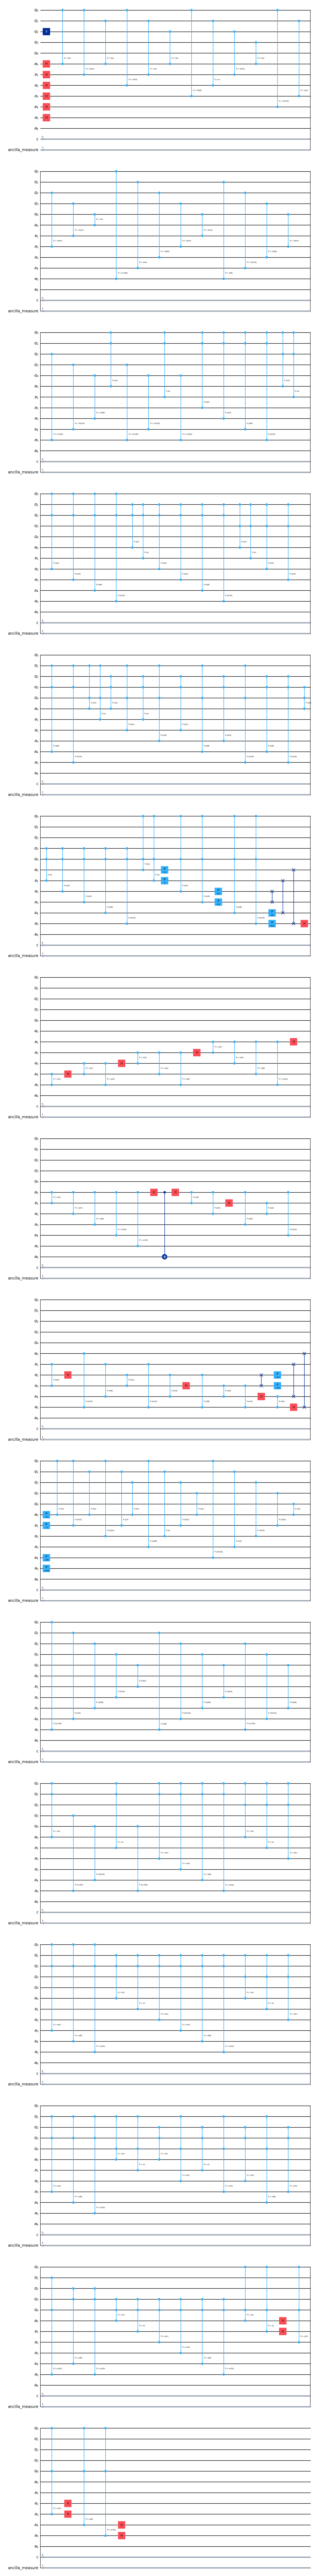

In [9]:
import random

qubit_count = variables
qr = QuantumRegister(qubit_count, 'q')
cr = ClassicalRegister(qubit_count, 'c')
ancilla = QuantumRegister(1 + m, 'a')
ancilla_measure = ClassicalRegister(1 + m, 'ancilla_measure')
qc = QuantumCircuit(qr, ancilla, cr, ancilla_measure)


test_state = [random.randint(0, 1) for _ in range(variables)] 
for i, state in enumerate(test_state):
    if state == 1:
        qc.x(qr[i])

# Generate y to be f(test_state) + 1 or f(test_state) - 1 with equal probability
y = evaluate_QUBO(test_state) + (-1)**(random.randint(0, 1))
oracle1(qc, [q for q in qr] + [q for q in ancilla], y = y)

qc.draw("mpl")

In [10]:
qc.measure_all()

# Instanciar Statevector
sampler = StatevectorSampler()
shots = 100000
 

job = sampler.run([qc], shots=shots)
 
# Extract the result for the 0th pub (this example only has one pub).
result = job.result()[0]
counts = result.data.meas.get_counts()

print(f"Oracle output in a computational basis state test_state = {test_state[::-1]}: {counts}")
print(f"f(test_state) = {evaluate_QUBO(test_state)}")
print(f"y value: {y}")

Oracle output in a computational basis state test_state = [0, 0, 1, 0, 0]: {'100000000100': 100000}
f(test_state) = -3
y value: -2


### Implementación de Grover

Mostramos ahora cómo 1 iteración de Grover con $y = -4$ amplifica los estados con $f(x) < -4$.

- **Cuidado:** En principio, no sabemos si los estados con $f(x) < -4$ corresponden a más de la mitad de los estados o no.  

En caso de que existan más de $N/2$ estados con $f(x) < -4$, entonces con una iteración de Grover se amplifican los estados con $f(x) \geq -4$. En este caso se puede verificar que los estados amplificados cumplen $f(x) < -4$.


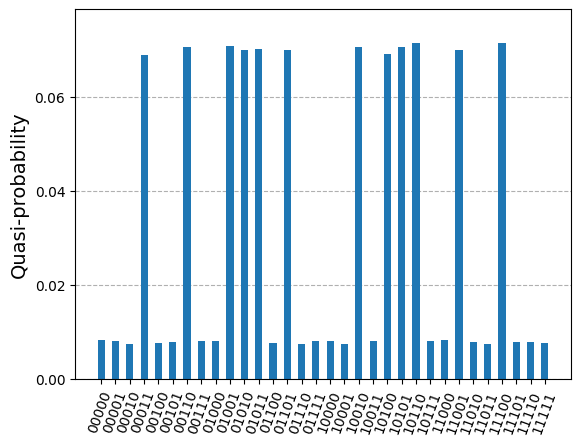

In [27]:
# Test Grover algorithm with 1 iteration with y = -1. 
qubit_count = variables
qr = QuantumRegister(qubit_count, 'q')
cr = ClassicalRegister(qubit_count, 'c')
ancilla = QuantumRegister(1 + m, 'a')
qc = QuantumCircuit(qr, ancilla, cr)


grover(qc, qr, oracle1, y = -4, ancilla=ancilla, iterations=1)

qc.measure(qr, cr)

# Instanciar Statevector
sampler = StatevectorSampler()
shots = 100000
 

job = sampler.run([qc], shots=shots)
 
# Extract the result for the 0th pub (this example only has one pub).
result = job.result()[0]
counts = result.data.c.get_counts()

probs = {}
for key in counts.keys():
    probs[key] = counts[key]/shots

plot_histogram(probs, bar_labels=False)

### Implementación completa de GAS:

Implementamos el algoritmo descrito al final de la introducción: 

- Inicializar $i = 0$, $y_0 = 0$, y $x^{(0)} = (x_1^{(0)}, x_2^{(0)}, \dots, x_n^{(0)}) = (0, 0, \dots, 0)$.

- Aplicar el algoritmo de Grover para obtener un estado tal que $f(x) < y_i$. Repetir la cantidad necesaria de veces para asegurar una alta probabilidad de encontrar un $x$ válido, en caso de existir.

- Si se encuentra un $x$ tal que $f(x) < y_i$, actualizar: $y_{i+1} = f(x)$, $x^{(i+1)} = x$, $i \leftarrow i + 1$, y volver al paso anterior.  

- En caso contrario, retornar $x^{(i)}$ como el estado que minimiza la función objetivo.

In [29]:
# Implement GAS. Stop if the Grover Search is performed 3 times without improving the minimum
y_value = 0
best_sol = [0 for _ in range(variables)]
end_condition = False
counter = 0
error_count = 0
max_error = 3
total_steps = 0

while not end_condition:

    # Set value of iteration for M = 1, 2, 4, etc.
    print(f"ITERATION {counter}: y = {y_value}:")

    sol_found = False
    for i in range(qubit_count):

        M = 2**(qubit_count - i)

        R = round( math.acos(math.sqrt(M)/math.sqrt(2**qubit_count)) / (2 * math.asin(math.sqrt(M)/math.sqrt(2**qubit_count))) - 1e-5 )


        qubit_count = variables
        qr = QuantumRegister(qubit_count, 'q')
        cr = ClassicalRegister(qubit_count, 'c')
        ancilla = QuantumRegister(1 + m, 'a')
        qc = QuantumCircuit(qr, ancilla, cr)

        grover(qc, qr, oracle1, y = y_value, ancilla=ancilla, iterations=R)

        qc.measure(qr, cr)

        sampler = StatevectorSampler()
        shots = 1

        job = sampler.run([qc], shots=shots)
        total_steps += R

        # Extract the result for the 0th pub (this example only has one pub).
        result = job.result()[0]
        counts = result.data.c.get_counts()

        sol_string = [q for q in counts.keys()][0][::-1]
        sol = [int(b) for b in sol_string]

        if evaluate_QUBO(sol) < y_value:
            y_value = evaluate_QUBO(sol)
            best_sol = sol
            print(f" > Better solution found: {sol}")
            print(f" > f(sol) = {evaluate_QUBO(sol)}")

            sol_found = True
            
            break

    if not sol_found:
        error_count += 1
        if error_count == max_error:
            print(f" > No better solution found after {max_error} iterations")
            print(f" > Exiting")
            end_condition = True

        else:
            print(f" > No better solution found")

    else:
        error_count = 0

    counter += 1

print(f"\nTotal steps (Applications of grover operator G): {total_steps}")
print(f"Total evaluations of f(x) for a classical brute-force approach: {2**variables}")

ITERATION 0: y = 0:
 > Better solution found: [1, 1, 1, 1, 0]
 > f(sol) = -3
ITERATION 1: y = -3:
 > Better solution found: [1, 1, 0, 0, 1]
 > f(sol) = -4
ITERATION 2: y = -4:
 > Better solution found: [1, 1, 0, 0, 0]
 > f(sol) = -5
ITERATION 3: y = -5:
 > Better solution found: [1, 0, 0, 1, 0]
 > f(sol) = -6
ITERATION 4: y = -6:
 > No better solution found
ITERATION 5: y = -6:
 > No better solution found
ITERATION 6: y = -6:
 > No better solution found after 3 iterations
 > Exiting

Total steps (Applications of grover operator G): 21
Total evaluations of f(x) for a classical brute-force approach: 32


In [23]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [30]:
print(f"{bcolors.OKGREEN} > solution found: {['x' + str(i) + '=' + str(best_sol[i]) for i in range(variables)]}{bcolors.ENDC}")
print(f"{bcolors.OKGREEN} > f(sol) = {evaluate_QUBO(best_sol)}{bcolors.ENDC}")

 > solution found: ['x0=1', 'x1=0', 'x2=0', 'x3=1', 'x4=0']
 > f(sol) = -6
